<a href="https://colab.research.google.com/github/rndjv/pospuvav2/blob/main/codigo/mvp2_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MVP Machine Learning**

## Definição do Problema

Os transformadores de potência são os equipamentos vitais e críticos do sistema de potência, sua função é garantir o fornecimento ininterrupto de energia na instalação, porém, diversos tipos de falhas podem inutilizar um transformador de potência ou severamente subestimado, no cenário, todos os as falhas precisam ser monitoradas para garantir a confiabilidade do fornecimento de energia. Sempre que ocorre uma falha em um transformador, gases como CO2, CH4, C2H6, CO, H2, O2, N2 são gerados. Alguns desses gases, exceto CO2, N2 e O2, são absorvidos pelo óleo do transformador. A concentração desses gases no óleo dielétrico pode ser medida em partes por milhão ou ppm. Esta concentração de gases de falha no óleo é utilizada para diagnóstico de falhas.
O dataset base desse trabalho apresenta medidas das concentrações dos gases e outras grandezas autoexplicativas com sua respectiva expectativa de vida, levantadas de trasnformadores no Chile, Peru e Colômbia.
O objetivo do projeto é a obtenção de um modelo que determine a expectativa de vida dos equipamentos com base nos nas grandezas em questão

In [ ]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.model_selection import LeaveOneOut # para pequenos datasets
from sklearn.metrics import mean_squared_error # métrica de avaliação MSE
from sklearn.linear_model import LinearRegression # algoritmo Regressão Linear
from sklearn.linear_model import Ridge # algoritmo Regularização Ridge
from sklearn.linear_model import Lasso # algoritmo Regularização Lasso
from sklearn.neighbors import KNeighborsRegressor # algoritmo KNN
from sklearn.tree import DecisionTreeRegressor # algoritmo Árvore de Regressão
from sklearn.svm import SVR # algoritmo SVM
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.feature_selection import SelectKBest # para a Seleção Univariada
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

## Carga de Dados

O dataset não possui muitas amostras, mas a escolha dele foi devido à aplicação prática, além de no mvp anterior como o dataset escolhido foi muito grande, o desenvolvimento no colab foi impactado.Assim, como um dataset menor foi possível testar mais modelos e com várias alterações de parâmetros.

In [ ]:
# Carga do dataset

df=pd.read_csv("https://raw.githubusercontent.com/rndjv/pospuvav2/main/dataset/Failure_Analysis_in_power_transformers.csv")

print(df.head())
print("Shape = ", df.shape)

   Hydrogen  Oxigen  Nitrogen  Methane   CO   CO2  Ethylene  Ethane  \
0      2845    5860     27842     7406   32  1344     16684    5467   
1     12886      61     25041      877   83   864         4     305   
2      2820   16400     56300      144  257  1080       206      11   
3      1099      70     37520      545  184  1402         6     230   
4      3210    3570     47900      160  360  2130         4      43   

   Acethylene  DBDS  Power factor  Interfacial V  Dielectric rigidity  \
0           7  19.0          1.00             45                   55   
1           0  45.0          1.00             45                   55   
2        2190   1.0          1.00             39                   52   
3           0  87.0          4.58             33                   49   
4           4   1.0          0.77             44                   55   

   Water content  Health index  Life expectation  
0              0          95.2              19.0  
1              0          85.5  

## Análise de Dados

### Estatísticas Descritivas

No dataset não há nenhuma valor nulo e o target é do tipo float, assim, os modelos de regressão foram os escolhidos para o mvp.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Hydrogen             470 non-null    int64  
 1   Oxigen               470 non-null    int64  
 2   Nitrogen             470 non-null    int64  
 3   Methane              470 non-null    int64  
 4   CO                   470 non-null    int64  
 5   CO2                  470 non-null    int64  
 6   Ethylene             470 non-null    int64  
 7   Ethane               470 non-null    int64  
 8   Acethylene           470 non-null    int64  
 9   DBDS                 470 non-null    float64
 10  Power factor         470 non-null    float64
 11  Interfacial V        470 non-null    int64  
 12  Dielectric rigidity  470 non-null    int64  
 13  Water content        470 non-null    int64  
 14  Health index         470 non-null    float64
 15  Life expectation     470 non-null    flo

In [ ]:
df.describe()

,Hydrogen,Oxigen,Nitrogen,Methane,CO,CO2,Ethylene,Ethane,Acethylene,DBDS,Power factor,Interfacial V,Dielectric rigidity,Water content,Health index,Life expectation
count,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000
mean,404.261702,8357.372340,47759.561702,79.695745,244.000000,1816.414894,162.923404,81.940426,91.491489,17.036596,1.849043,38.434043,53.495745,16.282979,27.504043,33.010426
std,2002.142678,14164.233283,13760.451816,489.320336,237.267485,2256.790519,1323.811504,342.573636,644.365828,46.735057,6.144009,6.178830,6.458906,17.115646,17.741458,17.791047
min,0.000000,57.000000,3600.000000,0.000000,10.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.050000,21.000000,27.000000,0.000000,13.400000,6.000000
25%,4.000000,496.000000,41700.000000,2.000000,66.000000,641.750000,0.000000,0.000000,0.000000,0.000000,0.570000,32.000000,51.000000,5.000000,13.400000,19.000000
50%,9.000000,3810.000000,49100.000000,3.000000,150.500000,1125.000000,3.000000,4.000000,0.000000,0.000000,1.000000,39.000000,54.000000,12.000000,13.400000,32.000000
75%,34.000000,14875.000000,55875.000000,7.000000,361.750000,2257.500000,6.000000,69.750000,0.000000,2.000000,1.000000,44.000000,56.000000,21.000000,38.550000,51.000000
max,23349.000000,249900.000000,85300.000000,7406.000000,1730.000000,24900.000000,16684.000000,5467.000000,9740.000000,227.000000,73.200000,57.000000,75.000000,183.000000,95.200000,51.000000


In [ ]:
print(df.isnull().sum())

Hydrogen               0
Oxigen                 0
Nitrogen               0
Methane                0
CO                     0
CO2                    0
Ethylene               0
Ethane                 0
Acethylene             0
DBDS                   0
Power factor           0
Interfacial V          0
Dielectric rigidity    0
Water content          0
Health index           0
Life expectation       0
dtype: int64


### Visualizações Unimodais

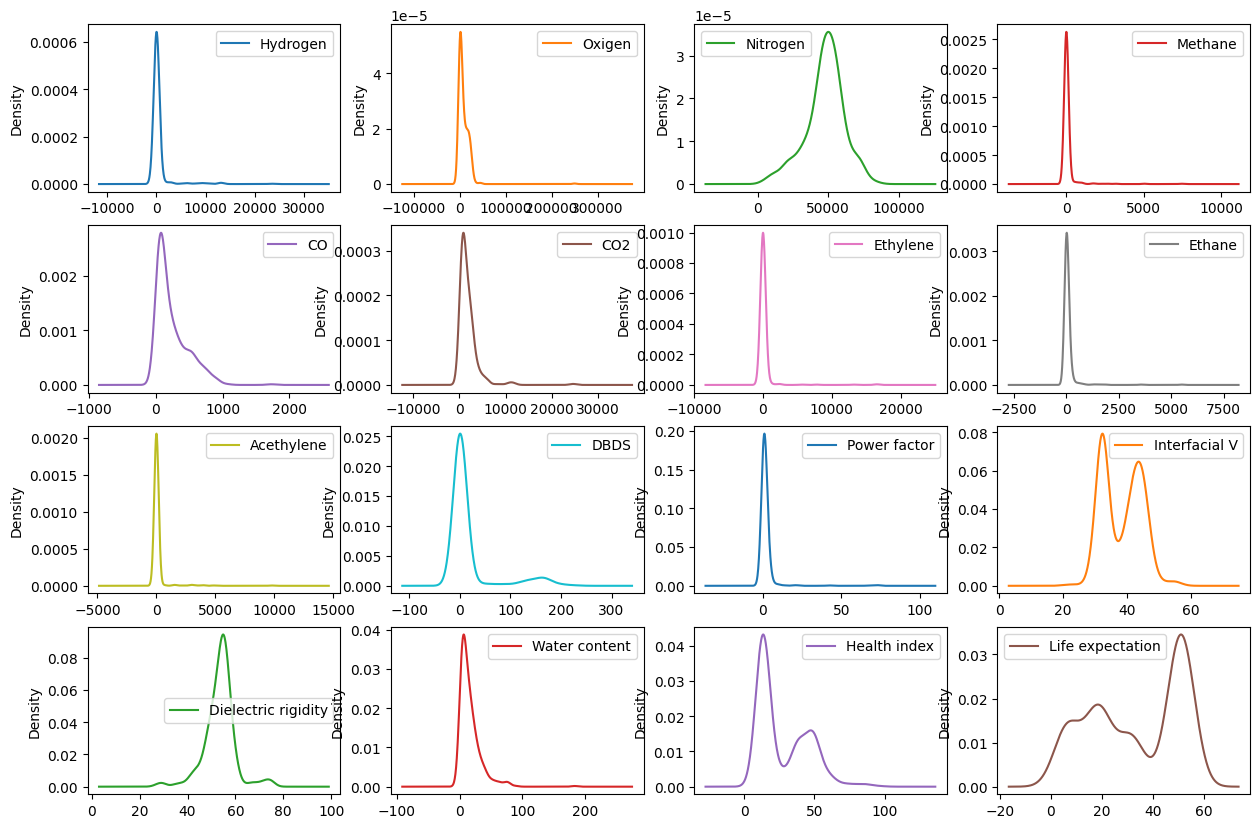

In [ ]:
df.plot(kind = 'density', subplots = True, layout = (4,4), sharex = False, figsize = (15,10))
plt.show()

Analisando as distribuições das grandezas, pode-se notar que exceto a life expectation, health index e interfacial V, todas as outras grandezas se aproximam de uma distribuição normal

### Visualizações Multimodais

<Axes: >

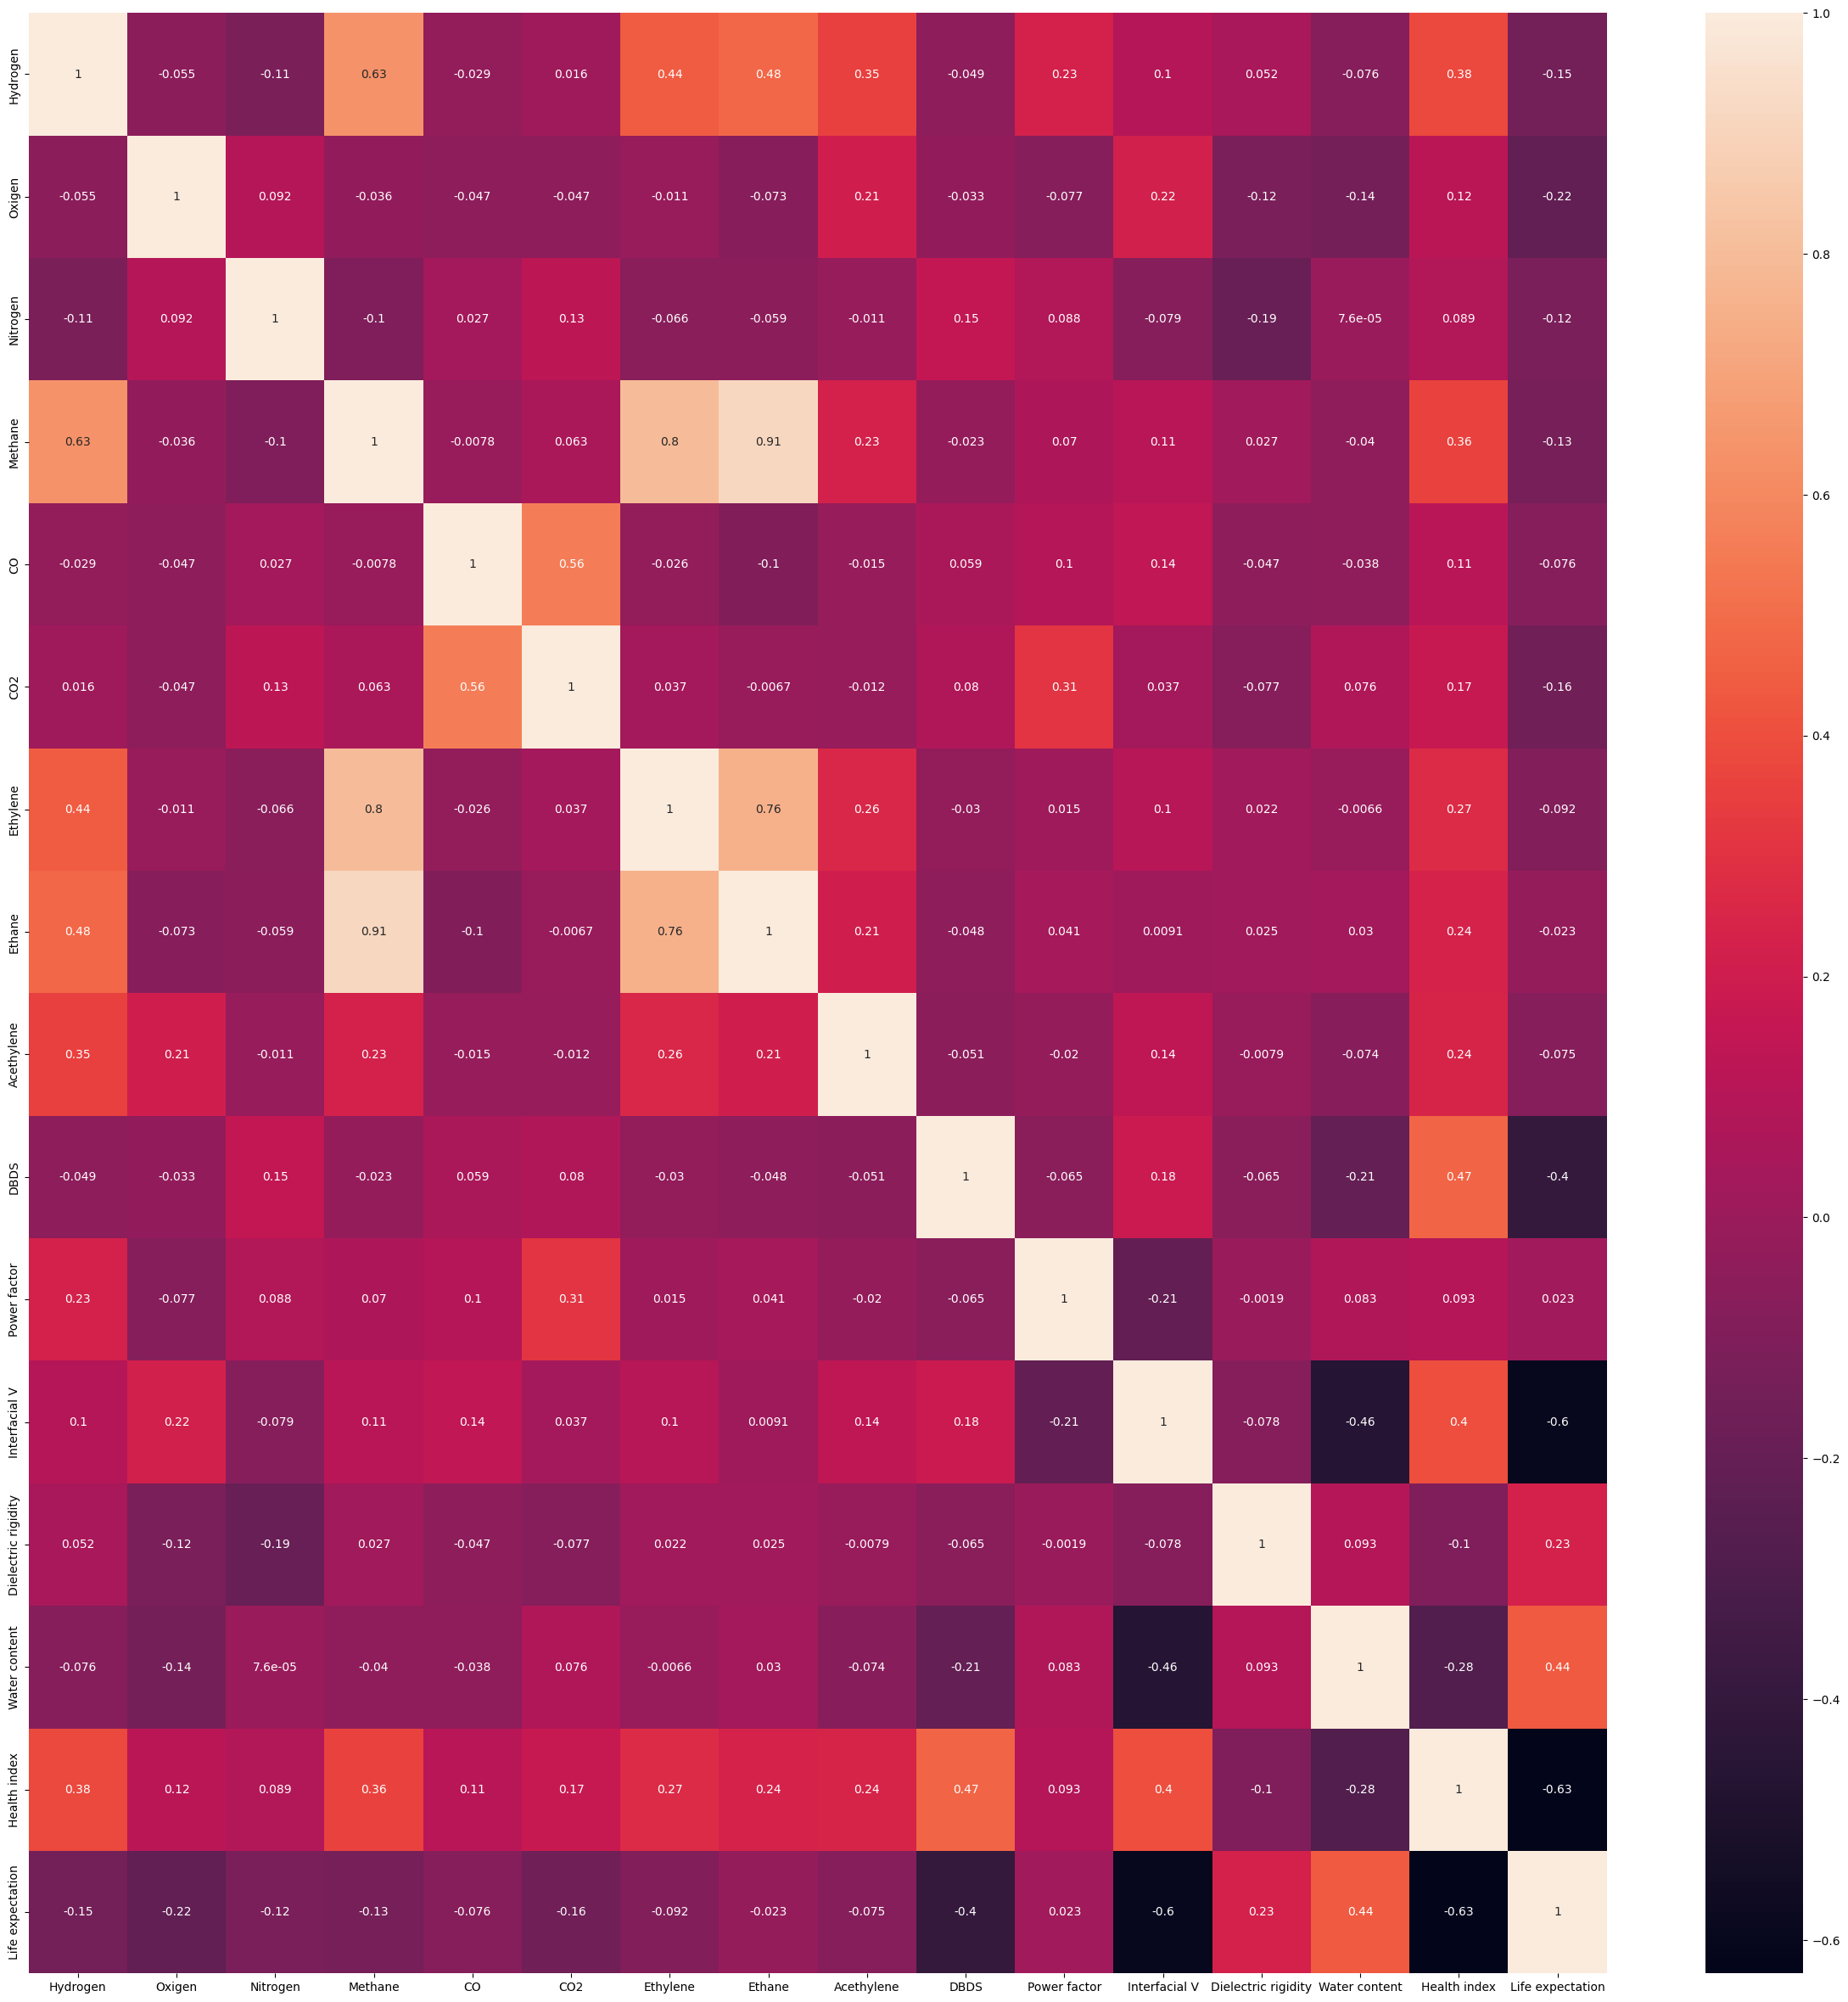

In [ ]:
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(),annot=True)

Com relação à correlação entre as variáveis, se nota que não há grande correlção, visto os valores mais altos serem próximos de 0,6

## Separação em conjunto de Treino e Teste com holdout

Nesse trecho os dados de entrada e saída são separados, sendo a life expectation a target. Vários valores de número de partições foram utilizados além do método leaveoneout, aplicado para pequenas amostras. Nesses testes o melhor resultado foi obtido com 3 partições.

In [ ]:
# Preparação dos dados

# Separação em bases de treino e teste (holdout)
array = df.values
X = array[:,0:14] # atributos
y = array[:,15] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7) # faz a divisão

# Criando os folds para a validação cruzada
num_particoes = 3 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds
loo = LeaveOneOut()


## Modelagem e Inferência

### Função para criação e avaliação de modelos: dados originais, padronizados e normalizados

Visando facilitar a execução de vários testes com parâmetros diferentes, foram criadas funções em que os modelos são iniciados e os pipelines criados. Nos pipeline foram usados os dados originais, normalizados e padronizados.

In [ ]:
def modelos_e_pipeline(x, y, model_selection):
  # Modelagem

  # Definindo uma seed global para esta célula de código
  np.random.seed(7)

  # Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
  pipelines = []
  results = []
  names = []

  # Transformações que serão utilizadas
  standard_scaler = ('StandardScaler', StandardScaler())
  min_max_scaler = ('MinMaxScaler', MinMaxScaler())

  # Algortimos uitilizados
  lr = ('LR', LinearRegression())
  ridge = ('Ridge', Ridge())
  lasso = ('Lasso', Lasso())
  knn = ('KNN', KNeighborsRegressor())
  cart = ('CART', DecisionTreeRegressor())
  svr = ('SVM', SVR())
  gpr = ('GPR', GaussianProcessRegressor())
  rfr = ('RFR', RandomForestRegressor())
  gbr = ('GBR', GradientBoostingRegressor())
  etr = ('ETR', ExtraTreesRegressor())
  abr = ('ABR', AdaBoostRegressor())

  # Montando os pipelines

  # Dataset original
  pipelines.append(('LR-orig', Pipeline([lr])))
  pipelines.append(('Ridge-orig', Pipeline([ridge])))
  pipelines.append(('Lasso-orig', Pipeline([lasso])))
  pipelines.append(('KNN-orig', Pipeline([knn])))
  pipelines.append(('CART-orig', Pipeline([cart])))
  pipelines.append(('SVM-orig', Pipeline([svr])))
  pipelines.append(('RFR-orig', Pipeline([rfr])))
  pipelines.append(('GBR-orig', Pipeline([gbr])))
  pipelines.append(('ETR-orig', Pipeline([etr])))
  pipelines.append(('ABR-orig', Pipeline([abr])))

  # Dataset Padronizado
  pipelines.append(('LR-padr', Pipeline([standard_scaler, lr])))
  pipelines.append(('Ridge-padr', Pipeline([standard_scaler, ridge])))
  pipelines.append(('Lasso-padr', Pipeline([standard_scaler, lasso])))
  pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
  pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
  pipelines.append(('SVM-padr', Pipeline([standard_scaler, svr])))
  pipelines.append(('RFR-padr', Pipeline([standard_scaler, rfr])))
  pipelines.append(('GBR-padr', Pipeline([standard_scaler, gbr])))
  pipelines.append(('ETR-padr', Pipeline([standard_scaler, etr])))
  pipelines.append(('ABR-padr', Pipeline([standard_scaler, abr])))


  # Dataset Normalizado
  pipelines.append(('LR-norm', Pipeline([min_max_scaler,lr])))
  pipelines.append(('Ridge-norm', Pipeline([min_max_scaler,ridge])))
  pipelines.append(('Lasso-norm', Pipeline([min_max_scaler,lasso])))
  pipelines.append(('KNN-norm', Pipeline([min_max_scaler,knn])))
  pipelines.append(('CART-norm', Pipeline([min_max_scaler,cart])))
  pipelines.append(('SVM-norm', Pipeline([min_max_scaler,svr])))
  pipelines.append(('RFR-norm', Pipeline([min_max_scaler, rfr])))
  pipelines.append(('GBR-norm', Pipeline([min_max_scaler, gbr])))
  pipelines.append(('ETR-norm', Pipeline([min_max_scaler, etr])))
  pipelines.append(('ABR-norm', Pipeline([min_max_scaler, abr])))



  # Executando os pipelines
  scoring = 'neg_mean_squared_error'
  for name, model in pipelines:
      cv_results = cross_val_score(model, x, y, cv=model_selection, scoring=scoring, n_jobs=-1)
      #cv_results = cross_val_score(model, X_train, y_train, cv=loo, scoring=scoring, n_jobs=-1)
      results.append(cv_results)
      names.append(name)
      msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
      print(msg)

  # Boxplot de comparação dos modelos
  fig = plt.figure(figsize=(25,6))
  fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
  ax = fig.add_subplot(111)
  plt.boxplot(results)
  ax.set_xticklabels(names, rotation=90)
  plt.show()

### Função para seleção de atributos

Além da função citada anteriormente, também foi criada uma função com obejtivo de facilitar a seleção de atributos. Nessa função as entradas são os dados de entrada e saída, de treino e teste. A função score recebe a f_regression e a mutual_info_regression, cada um utilizando métodos diferentes para a avaliação da importância dos atributos.
O treinamento dda seleção é realizada com o conjunto de treino somente, e depois aplicada aos dados de teste, para evitar o vazamento de dados.

In [ ]:
def selecao_de_atributos(x_treino, y_treino, x_teste, funcao_score, n_melhores):
  # SelectKBest

  # Seleção de atributos com SelectKBest
  best_var = SelectKBest(score_func= funcao_score, k=n_melhores)

  # Executa a função de pontuação em (X_train, y_train) e obtém os atributos selecionados
  best_var.fit(x_treino, y_treino)

  # transform train input data
  X_train_fs = best_var.transform(x_treino)
  # transform test input data
  X_test_fs = best_var.transform(x_teste)

  # what are scores for the features
  for i in range(len(best_var.scores_)):
    print('Feature %d: %f' % (i, best_var.scores_[i]))
  # plot the scores
  plt.bar([i for i in range(len(best_var.scores_))], best_var.scores_)
  plt.show()


  print("\nScores dos Atributos Originais:", best_var.scores_)
  print("\nAtributos Selecionados:", best_var.get_feature_names_out(input_features=df.columns[0:14]))
  return X_train_fs, X_test_fs

### Seleção de atributos

#### Utilizando f_regression

Com a utilização da f_regression o número de atributos escolhidos doi 4, pois como se pode ver no gráfico, são 4 os atributos que mais se destacam dentre o demais.

Feature 0: 9.047965
Feature 1: 18.671940
Feature 2: 7.506763
Feature 3: 6.844004
Feature 4: 3.317699
Feature 5: 9.298924
Feature 6: 2.895070
Feature 7: 0.135841
Feature 8: 1.727093
Feature 9: 82.711205
Feature 10: 0.276665
Feature 11: 213.585341
Feature 12: 17.299689
Feature 13: 84.197610


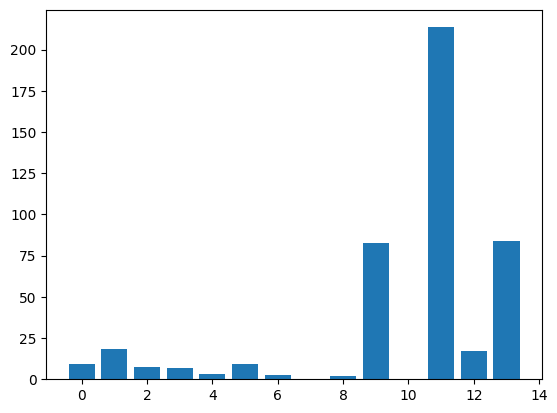


Scores dos Atributos Originais: [9.04796474e+00 1.86719396e+01 7.50676264e+00 6.84400372e+00
 3.31769904e+00 9.29892420e+00 2.89506958e+00 1.35841134e-01
 1.72709349e+00 8.27112051e+01 2.76665374e-01 2.13585341e+02
 1.72996890e+01 8.41976097e+01]

Atributos Selecionados: ['Oxigen' 'DBDS' 'Interfacial V' 'Water content']
(376, 4) (94, 4)


In [ ]:
X_train_fr, X_test_fr = selecao_de_atributos(X_train, y_train, X_test, f_regression,4)
print(X_train_fr.shape, X_test_fr.shape)

#### Utilizando mutual_info_regression

Com a utilização da mutual_info_regression os atributos são 6, conforme gráfico da importância dos atributos.

Feature 0: 0.299121
Feature 1: 0.166518
Feature 2: 0.051240
Feature 3: 0.255286
Feature 4: 0.073905
Feature 5: 0.043683
Feature 6: 0.103836
Feature 7: 0.257796
Feature 8: 0.084327
Feature 9: 0.359732
Feature 10: 0.330688
Feature 11: 0.420679
Feature 12: 0.101790
Feature 13: 0.603782


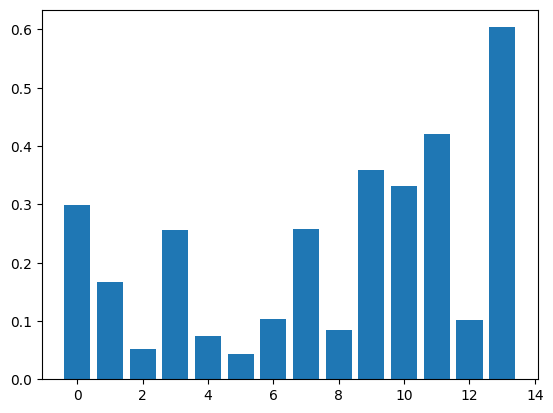


Scores dos Atributos Originais: [0.29912134 0.16651759 0.05123985 0.25528565 0.07390482 0.04368282
 0.10383564 0.25779602 0.08432744 0.3597318  0.33068791 0.4206788
 0.1017904  0.60378169]

Atributos Selecionados: ['Hydrogen' 'Ethane' 'DBDS' 'Power factor' 'Interfacial V' 'Water content']
(376, 6) (94, 6)


In [ ]:
X_train_mir, X_test_mir = selecao_de_atributos(X_train, y_train, X_test, mutual_info_regression, 6)
print(X_train_mir.shape, X_test_mir.shape)

### Avaliação de Modelos

Na estapa de avaliação de modelos, foram testadas os dados originais, os dados com feature selection utilizando f_regression e mutual_info_regression, e esses conbinados com os métodos de leaveoneout e kfolds.

Os melhores resultados em todos os testes foram utilizando o kfolds com 3 partições. O loo aumentava bastante o tempo de processamento do algoritmo, assim, os trechos com o loo foram comentados para redução do tempo de execução.

#### Avaliação de modelos sem feature selection

LR-orig: -215.668 (68.856)
Ridge-orig: -215.672 (68.866)
Lasso-orig: -216.432 (71.149)
KNN-orig: -236.652 (15.236)
CART-orig: -184.620 (52.553)
SVM-orig: -267.692 (24.868)
RFR-orig: -83.858 (11.580)
GBR-orig: -87.511 (19.496)
ETR-orig: -77.975 (10.159)
ABR-orig: -102.558 (0.948)
LR-padr: -215.668 (68.856)
Ridge-padr: -213.530 (67.056)
Lasso-padr: -192.707 (46.174)
KNN-padr: -126.611 (11.734)
CART-padr: -184.445 (76.891)
SVM-padr: -147.269 (19.582)
RFR-padr: -84.839 (12.047)
GBR-padr: -89.012 (18.588)
ETR-padr: -74.965 (10.073)
ABR-padr: -100.789 (12.111)
LR-norm: -215.668 (68.856)
Ridge-norm: -195.583 (55.642)
Lasso-norm: -210.708 (16.097)
KNN-norm: -121.768 (18.457)
CART-norm: -160.018 (41.667)
SVM-norm: -168.671 (24.257)
RFR-norm: -83.073 (12.320)
GBR-norm: -88.277 (19.126)
ETR-norm: -77.429 (9.380)
ABR-norm: -100.254 (10.910)


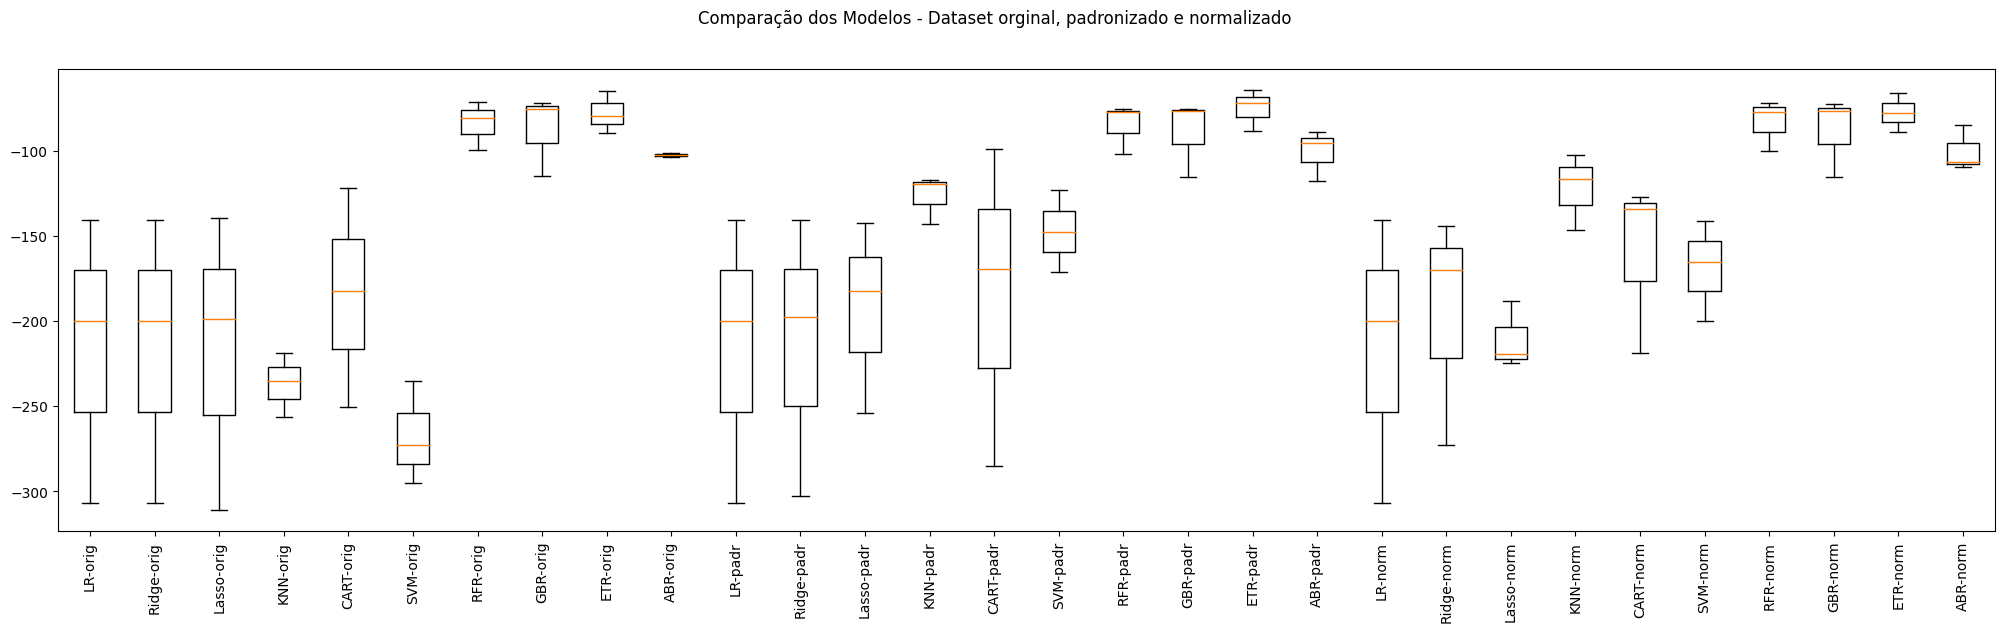

In [ ]:
modelos_e_pipeline(X_train, y_train, kfold)

In [ ]:
#modelos_e_pipeline(X_train, y_train, loo)

#### Avaliação de modelos com f_regression

LR-orig: -204.709 (58.702)
Ridge-orig: -204.712 (58.709)
Lasso-orig: -205.681 (60.484)
KNN-orig: -255.550 (12.050)
CART-orig: -229.607 (12.863)
SVM-orig: -335.439 (74.756)
RFR-orig: -109.768 (14.099)
GBR-orig: -114.437 (21.884)
ETR-orig: -110.017 (6.480)
ABR-orig: -126.654 (16.047)
LR-padr: -204.709 (58.702)
Ridge-padr: -204.459 (58.475)
Lasso-padr: -196.147 (42.497)
KNN-padr: -123.896 (20.468)
CART-padr: -232.574 (18.132)
SVM-padr: -142.038 (19.001)
RFR-padr: -111.685 (12.355)
GBR-padr: -115.576 (22.851)
ETR-padr: -110.165 (5.135)
ABR-padr: -136.130 (29.977)
LR-norm: -204.709 (58.702)
Ridge-norm: -201.828 (52.184)
Lasso-norm: -210.708 (16.097)
KNN-norm: -124.868 (6.995)
CART-norm: -249.947 (28.196)
SVM-norm: -156.176 (24.144)
RFR-norm: -108.504 (11.521)
GBR-norm: -115.883 (22.902)
ETR-norm: -112.078 (6.657)
ABR-norm: -134.886 (22.745)


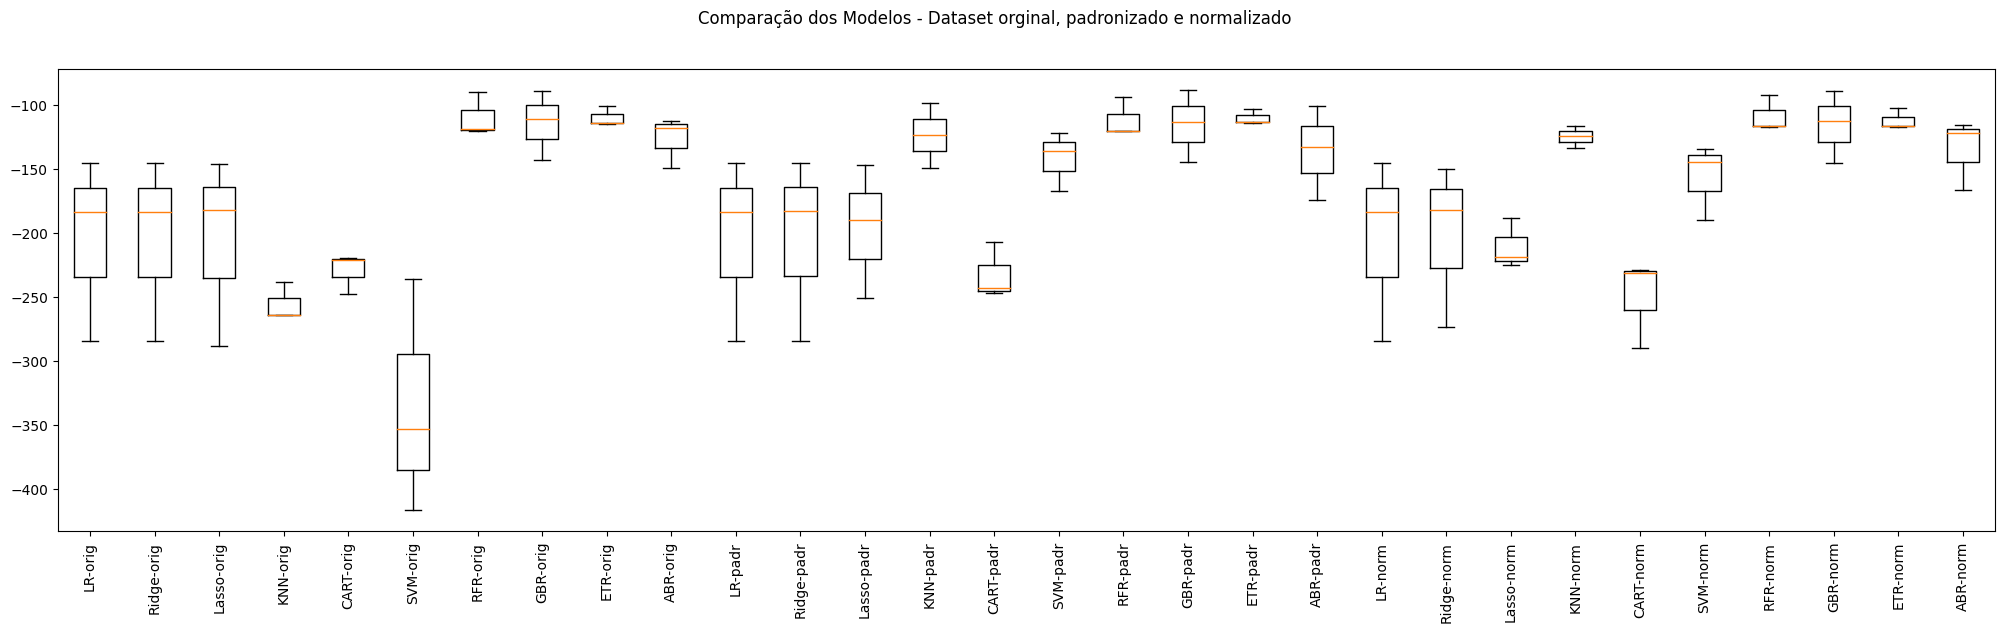

In [ ]:
modelos_e_pipeline(X_train_fr, y_train, kfold)

In [ ]:
#modelos_e_pipeline(X_train_fr, y_train, loo)

#### Avaliação de modelos com mutual_info_regression

LR-orig: -169.594 (17.643)
Ridge-orig: -169.592 (17.636)
Lasso-orig: -169.135 (16.610)
KNN-orig: -111.895 (11.341)
CART-orig: -190.183 (27.393)
SVM-orig: -301.899 (19.063)
RFR-orig: -84.041 (14.366)
GBR-orig: -80.306 (25.937)
ETR-orig: -82.656 (8.203)
ABR-orig: -110.380 (22.466)
LR-padr: -169.594 (17.643)
Ridge-padr: -169.443 (17.387)
Lasso-padr: -170.071 (17.638)
KNN-padr: -130.613 (23.289)
CART-padr: -182.954 (12.907)
SVM-padr: -150.258 (15.987)
RFR-padr: -84.772 (12.896)
GBR-padr: -82.436 (24.637)
ETR-padr: -83.805 (6.620)
ABR-padr: -107.579 (8.284)
LR-norm: -169.594 (17.643)
Ridge-norm: -166.844 (12.322)
Lasso-norm: -210.927 (16.214)
KNN-norm: -143.266 (22.778)
CART-norm: -187.200 (20.559)
SVM-norm: -158.070 (19.611)
RFR-norm: -85.441 (13.590)
GBR-norm: -81.119 (25.833)
ETR-norm: -82.901 (7.424)
ABR-norm: -120.195 (23.576)


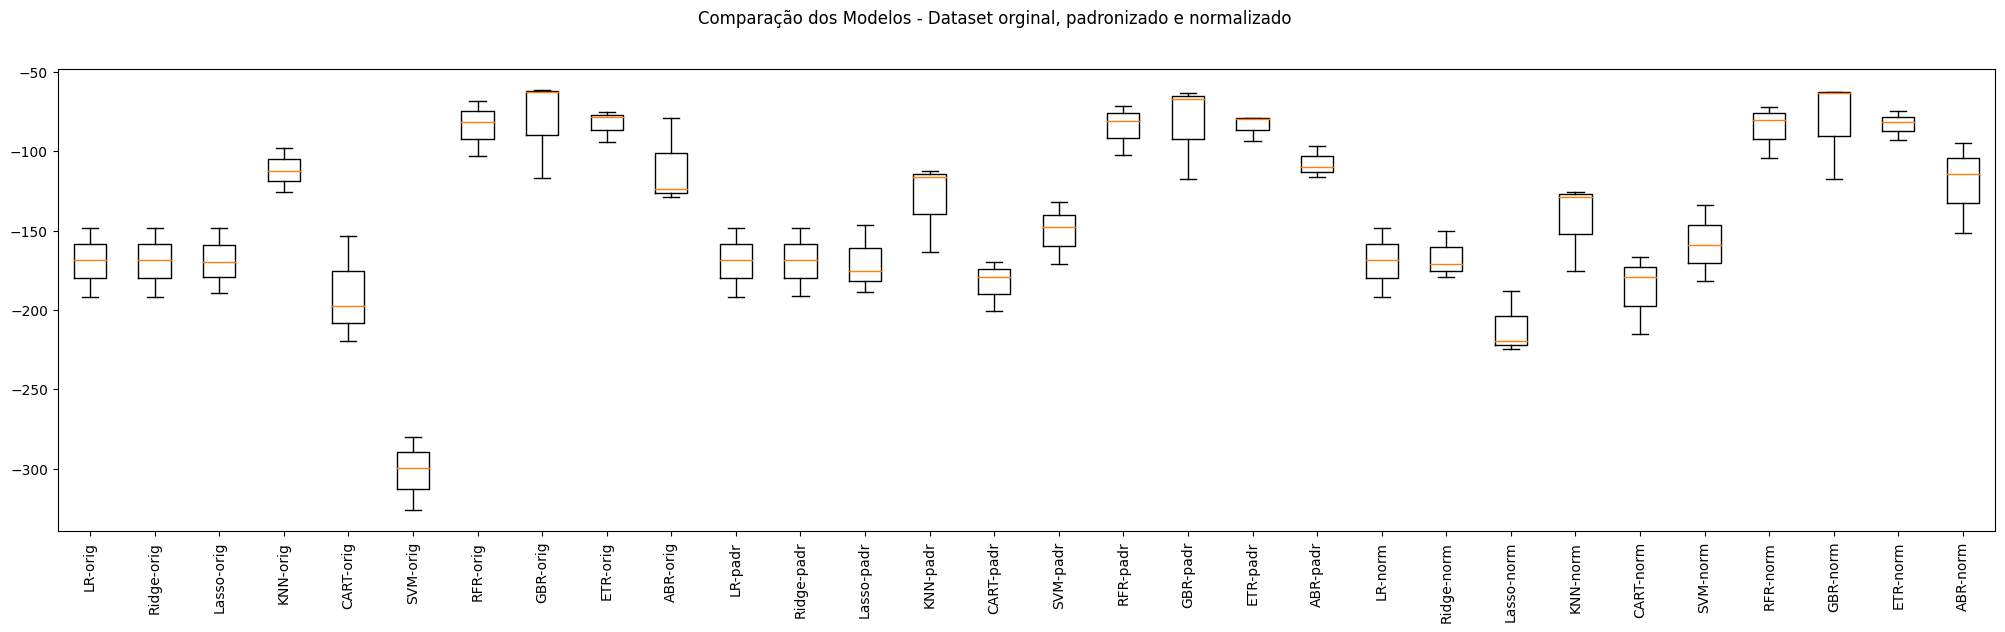

In [ ]:
modelos_e_pipeline(X_train_mir, y_train, kfold)

In [ ]:
#modelos_e_pipeline(X_train_mir, y_train, loo)

Em todas os testes realizados os melhores resultados foram atingidos quase sempre com o algortimo de etr e com a quantidade total dos atributos, apresentando uma variação entre os originais, normalizados e padronizados que dependia da rodada, fato normal em um processo estocástico.

### Otimização dos hiperparâmetros

Na etapa de otimização foi escolhido o modelo que obteve os melhores resultados na etapa anterior. Para a variação dos parâmetros, foram escolhidos dois atributos que em pesquisa foram encontrados com mais frequência.

O resultado também variou dentro de uma pequena margem em cada rodada.

In [ ]:
# Tuning do ETR

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
etr = ('ETR', ExtraTreesRegressor())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('etr-orig', Pipeline(steps=[etr])))
pipelines.append(('etr-padr', Pipeline(steps=[standard_scaler, etr])))
pipelines.append(('etr-norm', Pipeline(steps=[min_max_scaler, etr])))

param_grid = {
    'ETR__n_estimators': [10, 50, 100, 500, 1000, 5000],
    'ETR__max_features': [5,10,15,20,25,30],
}
scoring = 'neg_mean_squared_error'

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)

    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print(" %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

 etr-orig - Melhor: -74.647447 usando {'ETR__max_features': 25, 'ETR__n_estimators': 50}
 etr-padr - Melhor: -74.560137 usando {'ETR__max_features': 15, 'ETR__n_estimators': 100}
 etr-norm - Melhor: -73.246975 usando {'ETR__max_features': 20, 'ETR__n_estimators': 50}


##Finalização do Modelo

Para a criação do modelo final, o artifício da criação de uma função para facilitar várias execuções. Os atributos do algortimo obtídos na etapa anterior foram ecolhidos na melhor rodada encontrada. Foram criadas funções com o scaler e sem o scaler, pois como já dito o melhor resultado variou entre os três tipos.

Nessa etapa todo o dataset de treino foi utilizado, tanto para a etapa de scaler quanto para a etapa de treino. O teste só é utilizado nos modelos de scaler e etr treinados com os dados de treino.

In [ ]:
def modelo_final_com_scaler(x_treino, y_treino, x_teste, y_teste, scaler_mode):

  # Aplicando a normalização no conjuntode treino
  scaler = scaler_mode.fit(x_treino) # ajuste do scaler com o conjunto de treino
  rescaledX = scaler.transform(x_treino) # aplicação da padronização no conjunto de treino

  # Criando um modelo com todo o conjunto de treino
  model = ExtraTreesRegressor(max_features= 20, n_estimators= 50)
  model.fit(rescaledX, y_treino)

  # Fazendo as predições com o conjunto de teste
  rescaledX_test = scaler.transform(x_teste)
  predictions = model.predict(rescaledX_test)

  # Estimando o MSE e o RMSE no conjunto de teste
  mse = mean_squared_error(y_teste, predictions)
  print("MSE %0.2f" % mse)
  print("RMSE %0.2f" % np.sqrt(abs(mse)))

In [ ]:
def modelo_final_sem_scaler(x_treino, y_treino, x_teste, y_teste):

  # Criando um modelo com todo o conjunto de treino
  model = ExtraTreesRegressor(max_features= 20, n_estimators= 10)
  model.fit(x_treino, y_treino)

  # Fazendo as predições com o conjunto de teste

  predictions = model.predict(x_teste)

  # Estimando o MSE e o RMSE no conjunto de teste
  mse = mean_squared_error(y_teste, predictions)
  print("MSE %0.2f" % mse)
  print("RMSE %0.2f" % np.sqrt(abs(mse)))

In [ ]:
modelo_final_sem_scaler(X_train, y_train, X_test, y_test)

MSE 103.62
RMSE 10.18


In [ ]:
modelo_final_com_scaler(X_train, y_train, X_test, y_test, StandardScaler())

MSE 109.52
RMSE 10.47


In [ ]:
modelo_final_com_scaler(X_train, y_train, X_test, y_test, MinMaxScaler())

MSE 96.94
RMSE 9.85


Como nas rodadas não foi obtido sempre um melhor modelo, mas sim uma alternância entre 3 modelos, o modelos final foi gerado para as três situações. No resultado final também se pode perceber uma pequena variação no resultado.

## Conclusão

Com uma aplicação de grande importância e relacionada com a minha atividade profissional, o dataset de expectativa de vida de transformadores baseada em grandezas medida no óleo e elétricas foi o escolhido, apesar do seu tamanho reduzido.
Como dito no início, no mvp anterior um grande dataset tem ganhos, mas gerou um impacto significativo na execução do projeto e esse menor permitiu várias rodadas e testes.
Vários modelos são testados nesse código, mas outros foram executados mas retirados devido ao tempo de execução e por não gerarem resultados significativos.
Nos apresentados, o ETR foi de forma majoritária o que que apresentou melhores resultados. A seleção de atributos permitiria a obtenção de conclusões com menos informações permitindo a medida de menos atributos para obtenção dos resultados, que pensando de forma prática, implicaria em redução de custos para a realização dos testes para obtenção das quanitdade de gases. Mas com o dataset em questão não foi possível chegar a essa conclusão.
O fato do dataset ter poucas amostras pode ser um fato que levou à variação dos resultados. Como se pode observar no modelo final, com todos os dados, os erros são menores e não necessariamente correspondem ao encontrado na etapa de avaliação do modelo.
No trabalho se percebe o grande ganho que o machine learnig tem nas atiivdades,não só no ramo utilizado nesse trabalho, bem como em todos. A grande variedade de modelos e parâmetros nos algortimos leva a uma dificuldade pela escolha. Mas com a maior utilização e familiaridade, essa questão não será obstáculo.